In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import h5py
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
SOG350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_04may16.nc', 'r')
SOG350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_05aug17.nc', 'r')
SOG150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_11may17.nc', 'r')
SOG150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SOG/Lagrangian_AKNS_crude_fakewinds_13nov17.nc', 'r')

In [5]:
SOG350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/t.hdf5', 'r')
SOG350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_02aug17/04jan20-11jan20/t.hdf5', 'r')
SOG150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_08may17/04jan20-11jan20/t.hdf5', 'r')
SOG150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_10nov17/04jan20-11jan20/t.hdf5', 'r')

In [6]:
TP350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_20nov17.nc', 'r')
TP350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_31may18.nc', 'r')
TP150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_17nov15.nc', 'r')
TP150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/TP/Lagrangian_AKNS_crude_fakewinds_TP_13oct18.nc', 'r')

In [7]:
TP350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/t.hdf5', 'r')
TP350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_31may18/04jan20-11jan20/t.hdf5', 'r')
TP150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_17nov15/04jan20-11jan20/t.hdf5', 'r')
TP150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')

In [8]:
SB350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_26dec16.nc', 'r')
SB350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_13oct18.nc', 'r')
SB150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_26jun16.nc', 'r')
SB150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/SB/Lagrangian_AKNS_crude_fakewinds_SB_02aug18.nc', 'r')

In [9]:
SB350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26dec16/04jan20-11jan20/t.hdf5', 'r')
## reusing TP forcing files because for wind event
SB350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')
SB150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26jun16/04jan20-11jan20/t.hdf5', 'r')
SB150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_02aug18/04jan20-11jan20/t.hdf5', 'r')

In [10]:
BP350high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_01may16.nc', 'r')
BP350low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_13oct18.nc', 'r')
BP150high = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_20nov17.nc', 'r')
BP150low = nc.Dataset('/ocean/vdo/MIDOSS/results/fakewinds/BP/Lagrangian_AKNS_crude_fakewinds_BP_19jul15.nc', 'r')

In [11]:
## reusing TP and SOG forcing files because for wind events
BP350hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/t.hdf5', 'r')
BP350lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/t.hdf5', 'r')
BP150hight = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/t.hdf5', 'r')
BP150lowt = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/BP/fakewinds_19jul15/04jan20-11jan20/t.hdf5', 'r')

In [12]:
SOG350highsal = np.array([])
SOG350lowsal = np.array([])
SOG150highsal = np.array([])
SOG150lowsal = np.array([])

TP350highsal = np.array([])
TP350lowsal = np.array([])
TP150highsal = np.array([])
TP150lowsal = np.array([])

SB350highsal = np.array([])
SB350lowsal = np.array([])
SB150highsal = np.array([])
SB150lowsal = np.array([])

BP350highsal = np.array([])
BP350lowsal = np.array([])
BP150highsal = np.array([])
BP150lowsal = np.array([])

for hr in range(1,168):
        
    SOG350highmask = np.ma.masked_equal(SOG350high['Thickness_2D'][hr,:].T, 0).mask
    SOG350highsal = np.append(SOG350highsal, 
                              np.ma.mean(np.ma.masked_array(SOG350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG350highmask)))
    
    SOG350lowmask = np.ma.masked_equal(SOG350low['Thickness_2D'][hr,:].T, 0).mask
    SOG350lowsal = np.append(SOG350lowsal, 
                              np.ma.mean(np.ma.masked_array(SOG350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG350lowmask)))
    
    SOG150highmask = np.ma.masked_equal(SOG150high['Thickness_2D'][hr,:].T, 0).mask
    SOG150highsal = np.append(SOG150highsal, 
                              np.ma.mean(np.ma.masked_array(SOG150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG150highmask)))
    
    SOG150lowmask = np.ma.masked_equal(SOG150low['Thickness_2D'][hr,:].T, 0).mask
    SOG150lowsal = np.append(SOG150lowsal, 
                              np.ma.mean(np.ma.masked_array(SOG150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SOG150lowmask)))
    
    TP350highmask = np.ma.masked_equal(TP350high['Thickness_2D'][hr,:].T, 0).mask
    TP350highsal = np.append(TP350highsal, 
                              np.ma.mean(np.ma.masked_array(TP350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP350highmask)))
    
    TP350lowmask = np.ma.masked_equal(TP350low['Thickness_2D'][hr,:].T, 0).mask
    TP350lowsal = np.append(TP350lowsal, 
                              np.ma.mean(np.ma.masked_array(TP350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP350lowmask)))
    
    TP150highmask = np.ma.masked_equal(TP150high['Thickness_2D'][hr,:].T, 0).mask
    TP150highsal = np.append(TP150highsal, 
                              np.ma.mean(np.ma.masked_array(TP150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP150highmask)))
    
    TP150lowmask = np.ma.masked_equal(TP150low['Thickness_2D'][hr,:].T, 0).mask
    TP150lowsal = np.append(TP150lowsal, 
                              np.ma.mean(np.ma.masked_array(TP150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = TP150lowmask)))
    
    SB350highmask = np.ma.masked_equal(SB350high['Thickness_2D'][hr,:].T, 0).mask
    SB350highsal = np.append(SB350highsal, 
                              np.ma.mean(np.ma.masked_array(SB350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB350highmask)))
    
    SB350lowmask = np.ma.masked_equal(SB350low['Thickness_2D'][hr,:].T, 0).mask
    SB350lowsal = np.append(SB350lowsal, 
                              np.ma.mean(np.ma.masked_array(SB350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB350lowmask)))
    
    SB150highmask = np.ma.masked_equal(SB150high['Thickness_2D'][hr,:].T, 0).mask
    SB150highsal = np.append(SB150highsal, 
                              np.ma.mean(np.ma.masked_array(SB150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB150highmask)))
    
    SB150lowmask = np.ma.masked_equal(SB150low['Thickness_2D'][hr,:].T, 0).mask
    SB150lowsal = np.append(SB150lowsal, 
                              np.ma.mean(np.ma.masked_array(SB150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = SB150lowmask)))
    
    BP350highmask = np.ma.masked_equal(BP350high['Thickness_2D'][hr,:].T, 0).mask
    BP350highsal = np.append(BP350highsal, 
                              np.ma.mean(np.ma.masked_array(BP350hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP350highmask)))
    
    BP350lowmask = np.ma.masked_equal(BP350low['Thickness_2D'][hr,:].T, 0).mask
    BP350lowsal = np.append(BP350lowsal, 
                              np.ma.mean(np.ma.masked_array(BP350lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP350lowmask)))
    
    BP150highmask = np.ma.masked_equal(BP150high['Thickness_2D'][hr,:].T, 0).mask
    BP150highsal = np.append(BP150highsal, 
                              np.ma.mean(np.ma.masked_array(BP150hight['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP150highmask)))
    
    BP150lowmask = np.ma.masked_equal(BP150low['Thickness_2D'][hr,:].T, 0).mask
    BP150lowsal = np.append(BP150lowsal, 
                              np.ma.mean(np.ma.masked_array(BP150lowt['Results']['salinity']['salinity_00' + "{0:03}".format(hr)][-1,:], 
                                                            mask = BP150lowmask)))
    
    

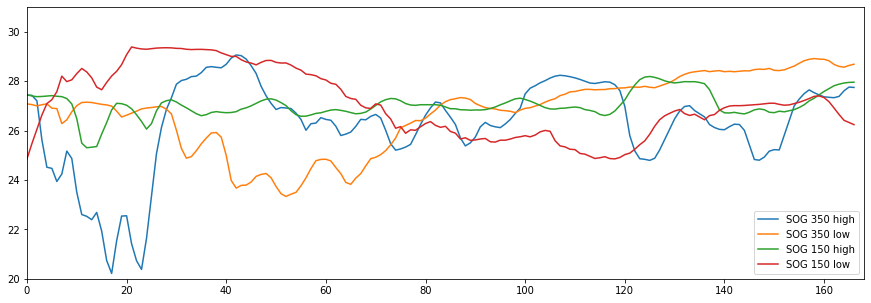

In [21]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(SOG350highsal, label = 'SOG 350 high')
ax.plot(SOG350lowsal, label = 'SOG 350 low')
ax.plot(SOG150highsal, label = 'SOG 150 high')
ax.plot(SOG150lowsal, label = 'SOG 150 low')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

In [27]:
SOGs0 = np.array([])
SOGs1 = np.array([])
SOGs2 = np.array([])
SOGs3 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    SOGs0 = np.append(SOGs0, SOG350hight['Results']['salinity'][key][-1, 251, 473])
    SOGs1 = np.append(SOGs1, SOG350lowt['Results']['salinity'][key][-1, 251, 473])
    SOGs2 = np.append(SOGs2, SOG150hight['Results']['salinity'][key][-1, 251, 473])
    SOGs3 = np.append(SOGs3, SOG150lowt['Results']['salinity'][key][-1, 251, 473])

In [36]:
SOG350hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 251, 473]

0.008378301

In [37]:
SOG350lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 251, 473]

1.0846929e-06

In [38]:
SOG150hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 251, 473]

7.1159615e-05

In [39]:
SOG150lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 251, 473]

0.007936645

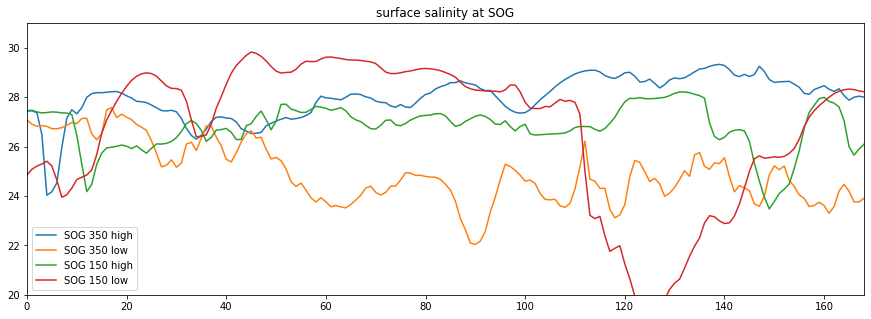

In [28]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(SOGs0, label = 'SOG 350 high')
ax.plot(SOGs1, label = 'SOG 350 low')
ax.plot(SOGs2, label = 'SOG 150 high')
ax.plot(SOGs3, label = 'SOG 150 low')
ax.set_title('surface salinity at SOG')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

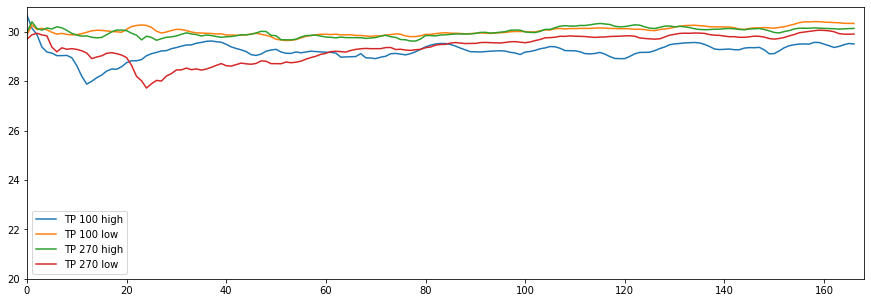

In [22]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(TP350highsal, label = 'TP 100 high')
ax.plot(TP350lowsal, label = 'TP 100 low')
ax.plot(TP150highsal, label = 'TP 270 high')
ax.plot(TP150lowsal, label = 'TP 270 low')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

In [29]:
TPs0 = np.array([])
TPs1 = np.array([])
TPs2 = np.array([])
TPs3 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    TPs0 = np.append(TPs0, TP350hight['Results']['salinity'][key][-1, 249, 342])
    TPs1 = np.append(TPs1, TP350lowt['Results']['salinity'][key][-1, 249, 342])
    TPs2 = np.append(TPs2, TP150hight['Results']['salinity'][key][-1, 249, 342])
    TPs3 = np.append(TPs3, TP150lowt['Results']['salinity'][key][-1, 249, 342])

In [40]:
TP350hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 249, 342]

0.014226422

In [41]:
TP350lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 249, 342]

0.006272231

In [42]:
TP150hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 249, 342]

0.029901715

In [43]:
TP150lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 249, 342]

0.044985626

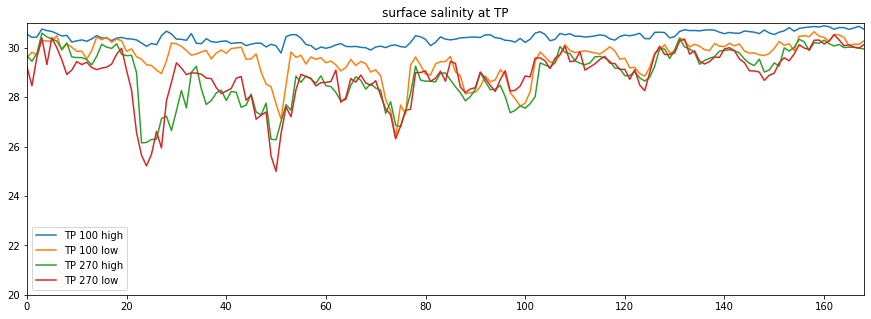

In [30]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(TPs0, label = 'TP 100 high')
ax.plot(TPs1, label = 'TP 100 low')
ax.plot(TPs2, label = 'TP 270 high')
ax.plot(TPs3, label = 'TP 270 low')
ax.set_title('surface salinity at TP')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

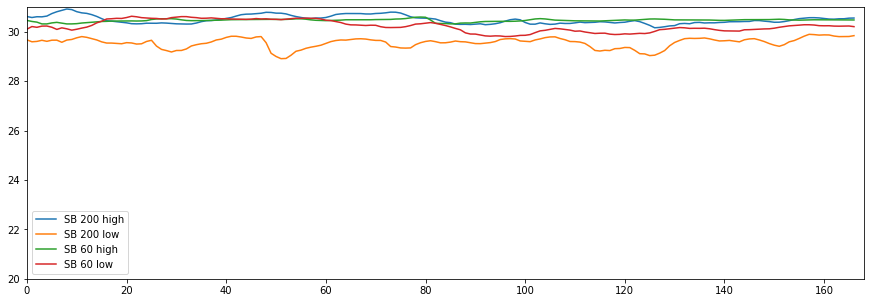

In [23]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(SB350highsal, label = 'SB 200 high')
ax.plot(SB350lowsal, label = 'SB 200 low')
ax.plot(SB150highsal, label = 'SB 60 high')
ax.plot(SB150lowsal, label = 'SB 60 low')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

In [31]:
SBs0 = np.array([])
SBs1 = np.array([])
SBs2 = np.array([])
SBs3 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    SBs0 = np.append(SBs0, SB350hight['Results']['salinity'][key][-1, 266, 255])
    SBs1 = np.append(SBs1, SB350lowt['Results']['salinity'][key][-1, 266, 255])
    SBs2 = np.append(SBs2, SB150hight['Results']['salinity'][key][-1, 266, 255])
    SBs3 = np.append(SBs3, SB150lowt['Results']['salinity'][key][-1, 266, 255])

In [44]:
SB350hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 266, 255]

0.012156113

In [45]:
SB350lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 266, 255]

8.178813e-05

In [46]:
SB150hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 266, 255]

0.0030425678

In [47]:
SB150lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 266, 255]

4.0095124e-06

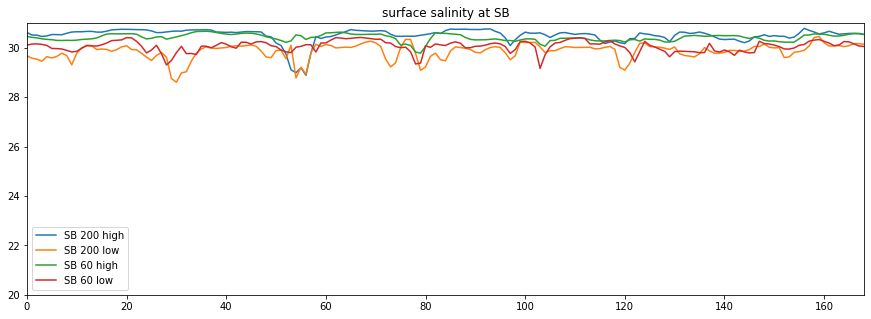

In [32]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(SBs0, label = 'SB 200 high')
ax.plot(SBs1, label = 'SB 200 low')
ax.plot(SBs2, label = 'SB 60 high')
ax.plot(SBs3, label = 'SB 60 low')
ax.set_title('surface salinity at SB')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

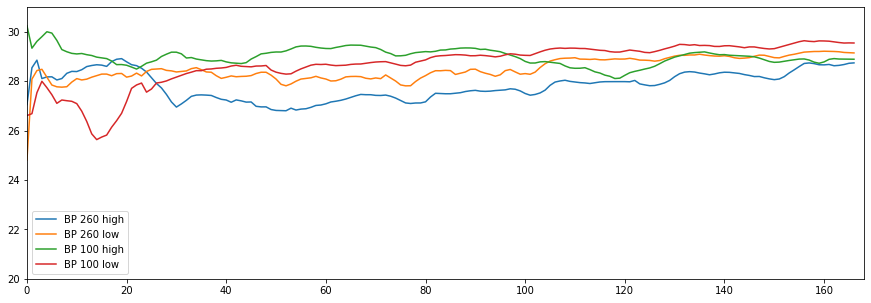

In [24]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(BP350highsal, label = 'BP 260 high')
ax.plot(BP350lowsal, label = 'BP 260 low')
ax.plot(BP150highsal, label = 'BP 100 high')
ax.plot(BP150lowsal, label = 'BP 100 low')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();

In [33]:
BPs0 = np.array([])
BPs1 = np.array([])
BPs2 = np.array([])
BPs3 = np.array([])

for key in list(SOG350hight['Results']['salinity'].keys()):
    BPs0 = np.append(BPs0, BP350hight['Results']['salinity'][key][-1, 298, 338])
    BPs1 = np.append(BPs1, BP350lowt['Results']['salinity'][key][-1, 298, 338])
    BPs2 = np.append(BPs2, BP150hight['Results']['salinity'][key][-1, 298, 338])
    BPs3 = np.append(BPs3, BP150lowt['Results']['salinity'][key][-1, 298, 338])

In [48]:
BP350hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 298, 338]

0.00033073095

In [49]:
BP350lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 298, 338]

0.0013778444

In [50]:
BP150hight['Results']['Diffusivity']['Diffusivity_00001'][-2, 298, 338]

0.026780345

In [51]:
BP150lowt['Results']['Diffusivity']['Diffusivity_00001'][-2, 298, 338]

0.0056438292

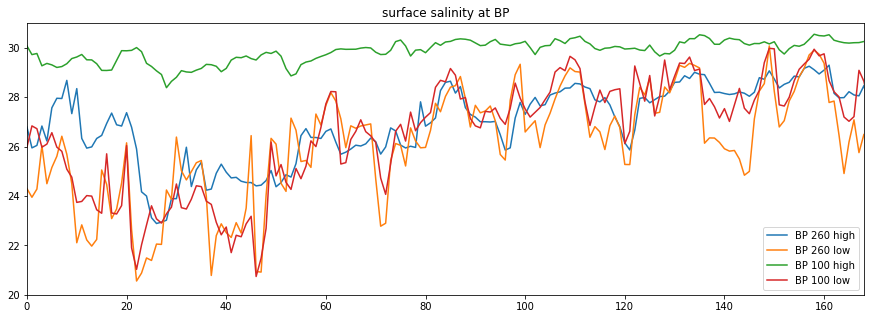

In [34]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(BPs0, label = 'BP 260 high')
ax.plot(BPs1, label = 'BP 260 low')
ax.plot(BPs2, label = 'BP 100 high')
ax.plot(BPs3, label = 'BP 100 low')
ax.set_title('surface salinity at BP')
ax.set_xlim(0,168)
ax.set_ylim(20,31)
ax.legend();